# Лабораторная работа 2

## Задание 1
Реализовать в среде MATLAB метод наискорейшего спуска, сопряженных градиентов, Ньютона, правильного симплекса, циклического покоординатного спуска, Хука-Дживса и случайного поиска, при реализации методов использовать аналитические значения производных и их разностные аппроксимации.

In [107]:
import math

import numpy as np
from sympy import lambdify
from sympy.abc import x, y

from functools import total_ordering


@total_ordering
class Point:
    """Класс точки функции и ее значения для более удобных манипуляций"""

    def __init__(self, x_p, value=float('inf')):
        self.x_point = x_p
        self.value = value

    def __eq__(self, other):
        return self.value == other.value

    def __le__(self, other):
            return self.value <= other.value
    
    def get_coords(self):
         return self.x_point


@total_ordering
class Point2:
    """Класс точки функции и ее значения для более удобных манипуляций"""

    def __init__(self, x_p, y_p, value=float('inf')):
        self.x_point = x_p
        self.y_point = y_p
        self.value = value

    def __eq__(self, other):
        return self.value == other.value

    def __le__(self, other):
            return self.value <= other.value
    
    def get_coords(self):
         return np.array([self.x_point, self.y_point])


def calcule_gradient(func, symbols, values) -> tuple[np.ndarray, int]:

    direvatives_matrix = [func.diff(arg) for arg in symbols]
    gm_k1 = np.array([lambdify(symbols, derevat)(*values) for derevat in direvatives_matrix])
    direvatives_calculatus = len(direvatives_matrix)

    return gm_k1, direvatives_calculatus


def hessian(func, symbols, values) -> np.ndarray:

    total_calculates = 0
    hessian = np.empty([len(symbols)] * 2)

    for row in range(hessian.ndim):
        for col in range(hessian.ndim):
            calculated_direvative = func.diff(symbols[col], symbols[row])
            total_calculates += 2

            hessian[row][col] = lambdify(symbols, calculated_direvative)(*values)
            total_calculates += 1
    
    return hessian, total_calculates


def bitByBitSearch(func, x, eps=10e-3):
    """Реализация метода поразрядного поиска. Возвращает точку минимума, значение минимума функции и количество вычислений"""

    cur_eps = 0.25 if 0.25 > eps else eps

    direction_to_right = True
    compute_number = 0
    
    func_arg = x
    last_point = Point(func_arg, func(func_arg))

    
    while True:

        while True:
            
            func_arg += cur_eps if direction_to_right else -1*cur_eps
            
            func_value = func(func_arg)
            func_point = Point(func_arg, func_value)
            compute_number += 1
            
            if func_point >= last_point:
                break
            else:
                last_point = func_point

        if cur_eps <= eps:
            break
        else:
            last_point = func_point
            direction_to_right = not direction_to_right
            cur_eps /= 4

    return last_point.get_coords(), last_point.value, compute_number


In [108]:
def fastest_downhill(func, start_point, eps):

    iteration_number = 0
    calcul_number = 0
    point = Point2(*start_point)

    func_lambd = lambdify([x, y], func)
    point.value = func_lambd(*start_point)

    direvatives_matrix = [func.diff(arg) for arg in [x, y]]
    calcul_number += 2

    while True:
        iteration_number += 1

        if iteration_number % 1000 == 0:
            print(f"{iteration_number} --- {gradient_norm}")

        gm_k1 = np.array([lambdify([x, y], derevat)(*point.get_coords()) for derevat in direvatives_matrix])
        calcul_number += len(direvatives_matrix)
        gradient_norm: float = np.linalg.norm(gm_k1)

        if gradient_norm < eps:
            break

        x_k = point.get_coords()
        F_min = lambda alpha: func_lambd(*(x_k - alpha * gm_k1))
        alpha_min, new_value, func_count = bitByBitSearch(F_min, 0)
        calcul_number += func_count

        x_new, y_new = x_k - alpha_min * gm_k1
        point = Point2(x_new, y_new, new_value)

    return point.get_coords(), point.value, iteration_number, calcul_number

In [109]:
def conjugate_gradients_method(func, start_point, eps):

    k = 0
    iteration_count = 0
    calcul_number = 0
    point = Point2(*start_point)
    func_lambd = lambdify([x, y], func)

    gm_k1, difs_count = calcule_gradient(func, [x, y], point.get_coords())
    calcul_number += difs_count

    p_0 = -gm_k1

    while True:
        iteration_count += 1

        F_min = lambda alpha: func_lambd(*(point.get_coords() + alpha * p_0))
        alpha_min, _, func_count = bitByBitSearch(F_min, 0)
        calcul_number += func_count

        x_k2 = point.get_coords() + alpha_min * p_0
        gm_k2, difs_count = calcule_gradient(func, [x, y], x_k2)
        calcul_number += difs_count

        gm_k2_norm = np.linalg.norm(gm_k2)
        if gm_k2_norm < eps:
            break

        if k + 1 == 2:
            beta = 0
            k = 0
        else:
            beta = gm_k2_norm**2 / np.linalg.norm(gm_k1)**2
            k += 1

        p_0 = -gm_k2 + beta * p_0
        point = Point2(*x_k2)
    
    return x_k2, func_lambd(*x_k2), iteration_count, calcul_number + 1

In [110]:
def cool_newton_method(func, start_point, eps):

    iteration_count = 0
    calcul_number = 0
    point = Point2(*start_point)
    func_lambd = lambdify([x, y], func)

    while True:
        iteration_count += 1

        gm_k1, difs_count = calcule_gradient(func, [x, y], point.get_coords())
        calcul_number += difs_count

        if np.linalg.norm(gm_k1) < eps:
            break

        func_hessian, hessian_count = hessian(func, [x, y], point.get_coords())
        calcul_number += hessian_count

        inv_hessian = np.linalg.inv(func_hessian)

        x_next = point.get_coords() - np.matmul(inv_hessian, gm_k1)
        point = Point2(*x_next)
    
    return point.get_coords(), func_lambd(*point.get_coords()), iteration_count, calcul_number + 1


In [111]:
from sympy import Symbol


def simplex_method(f, x_start, tol=1e-6):
    x, y = Symbol("x"), Symbol("y")
    alpha = 1  # коэффициент отражения
    sigma = 0.5  # коэффициент уменьшения симплекса
    max_iter = 500

    iter_count = 0
    calcul_number = 0
    
    f = lambdify([x, y], f)
    
    n = len(x_start)  # размерность пространства (2 для двумерного случая)
    simplex = np.zeros((n + 1, n))  # создаем начальный симплекс
    simplex[0] = x_start

    # Начальный симплекс создается путем добавления небольших смещений к начальной точке
    for i in range(1, n + 1):
        x = np.copy(x_start)
        x[i - 1] += 0.05  # небольшое смещение по одной из координат
        simplex[i] = x
    
    # f_values = np.apply_along_axis(f, 1, simplex)  # вычисляем значения функции в точках симплекса
    f_values = np.array(list(map(lambda sim_point: f(*sim_point), simplex)))
    calcul_number += np.size(simplex)
    iter_count = 0
    
    while iter_count < max_iter:
        iter_count += 1
        
        # Сортируем вершины симплекса по значениям функции
        idx = np.argsort(f_values)
        simplex = simplex[idx]
        f_values = f_values[idx]
        
        # Проверяем условие сходимости
        if np.std(f_values) < tol:
            break
        
        # Определяем центроид (среднее всех точек, кроме худшей)
        centroid = np.mean(simplex[:-1], axis=0)
        
        # Отражение худшей точки
        xr = centroid + alpha * (centroid - simplex[-1])
        fr = f(*xr)
        calcul_number += 1
        
        if fr < f_values[-1]:
            simplex[-1] = xr
            f_values[-1] = fr
            continue
        
        # Если сжатие не сработало, уменьшаем симплекс
        simplex[1:] = simplex[0] + sigma * (simplex[1:] - simplex[0])
        f_values[1:] = np.array(list(map(lambda sim_point: f(*sim_point), simplex[1:])))
        calcul_number += np.size(simplex[1:])
    
    return simplex[0], f_values[0], iter_count, calcul_number


In [112]:
from copy import copy

def cycle_coord_method(func, x_point, eps):
    iteration_count = 0
    calcul_number = 0
    point = Point2(*x_point)
    func_lambd = lambdify([x, y], func)

    point.value = func_lambd(*point.get_coords())
    calcul_number += 1

    while True:
        iteration_count += 1
        new_point = copy(point)
        for e_ind in range(len(x_point)):
            e_vec = np.zeros(len(x_point))
            e_vec[e_ind] = 1.0

            F_min = lambda alpha: func_lambd(*(new_point.get_coords() - alpha * e_vec))
            alpha_min, _, func_count = bitByBitSearch(F_min, 0)
            calcul_number += func_count

            new_point = Point2(*(new_point.get_coords() - alpha_min * e_vec), )
        
        new_point.value = func_lambd(*new_point.get_coords())
        calcul_number += 1

        if abs(point.value - new_point.value) < eps:
            break
        else:
            point = new_point

    return point.get_coords(), point.value, iteration_count, calcul_number

In [113]:
def hooke_jeeves(f, x0, epsilon=1e-6):
    """
    Поиск минимума функции методом Хука-Дживса.

    Параметры:
    f : функция от двух переменных
    x0 : начальная точка (список или массив)
    delta : шаг поискового движения
    epsilon : требуемая точность
    alpha : коэффициент увеличения шага базисного движения
    beta : коэффициент уменьшения шага поискового движения

    Возвращает:
    Минимальную точку и значение функции в этой точке.
    """

    iteration_count = 0
    calcul_number = 0

    delta=0.5
    alpha=2.0
    beta=0.5

    f = lambdify([x, y], f)
    
    def exploratory_search(f, x, delta):
        """Функция, выполняющая поисковое движение."""
        nonlocal calcul_number

        x_new = np.copy(x)
        for i in range(len(x)):
            # Пробуем движение вперед по каждой координате
            x_test = np.copy(x_new)
            x_test[i] += delta

            calcul_number += 2
            if f(*x_test) < f(*x_new):
                x_new = x_test
            else:
                # Если вперед хуже, пробуем назад
                x_test[i] -= 2 * delta

                calcul_number += 1
                if f(*x_test) < f(*x_new):
                    x_new = x_test
        return x_new

    x_base = np.array(x0)
    x_opt = exploratory_search(f, x_base, delta)

    while np.linalg.norm(x_opt - x_base) > epsilon or delta > epsilon:
        iteration_count += 1

        if np.linalg.norm(x_opt - x_base) > epsilon:
            # Базисное движение
            x_new = x_opt + alpha * (x_opt - x_base)
            x_base = x_opt
        else:
            # Снижение шага
            delta *= beta
            x_new = x_opt

        # Выполняем поисковое движение
        x_opt_new = exploratory_search(f, x_new, delta)

        calcul_number += 2
        if f(*x_opt_new) < f(*x_opt):
            x_opt = x_opt_new
        else:
            x_opt = x_base

    return x_opt, f(*x_opt), iteration_count, calcul_number + 1

In [114]:
from math import radians, sin, cos

def random_search_method(func, start_point, eps=.001):

    def get_random_unit_vector():
        M = 6
        degree_step = 60 # такой градус выбран для создания точек равностороннего шестиугольника

        for j in range(M):
            xi = np.array([
                sin(radians(degree_step * j)), 
                cos(radians(degree_step * j))
            ])

            yield xi
    
    iteration_count = 0
    calcul_number = 0
    alpha=2.0
    gamma=0.5

    func_lambd = lambdify([x, y], func)
    x_point = np.array(start_point)
    x_value = func_lambd(*x_point)
    calcul_number += 1

    unit_generator = get_random_unit_vector()
    xi_vector = None
    while True:
        iteration_count += 1

        try:
            xi_vector = next(unit_generator) # 3 шаг. Также и 6-ой шаг, в случае StopIteration

            while True:
                # 4
                y_point = x_point + alpha * xi_vector / np.linalg.norm(xi_vector)
                y_value = func_lambd(*y_point)
                calcul_number += 1

                # 5
                if y_value < x_value:
                    x_point = y_point
                    x_value = y_value
                else:
                    break

        except StopIteration:
            # 7
            if alpha < eps:
                break
            else:
                alpha *= gamma
                unit_generator = get_random_unit_vector()

    return x_point, x_value, iteration_count, calcul_number

## Задание 2

Протестировать работу реализованных методов на примере овражной функции:
$$
f(x)=x_{1}^{2}+\alpha*x_{2}^{2},
$$
при $\alpha$ равных 1, 250, 1000. При $\epsilon=10^{-3}$ и $\epsilon=10^{-5}$ сравнить скорость работы методов при различных значениях параметра   по числу итераций и по числу вызовов совокупности значений функций и производных.

---

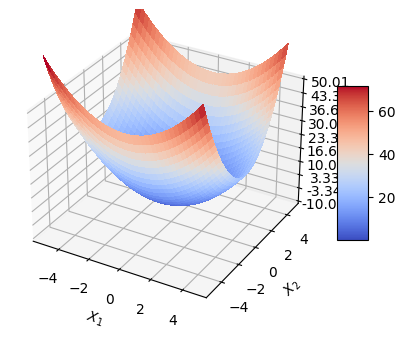

In [115]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from sympy.abc import x, y

research_function = lambda alpha: x**2 + alpha * y**2
start_point = [5.0, 5.0]

plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

alpha = 2.0
func_lambda = lambdify([x, y], research_function(alpha))
# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = func_lambda(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-10.01, 50.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel(r'$X_{1}$')
ax.set_ylabel(r'$X_{2}$')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

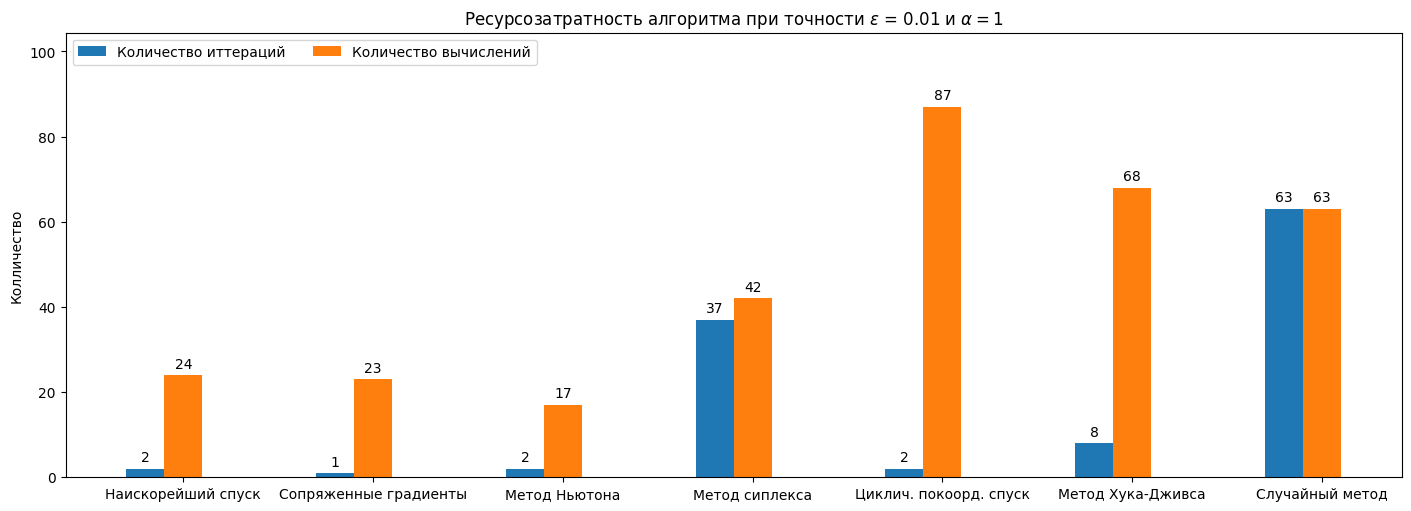

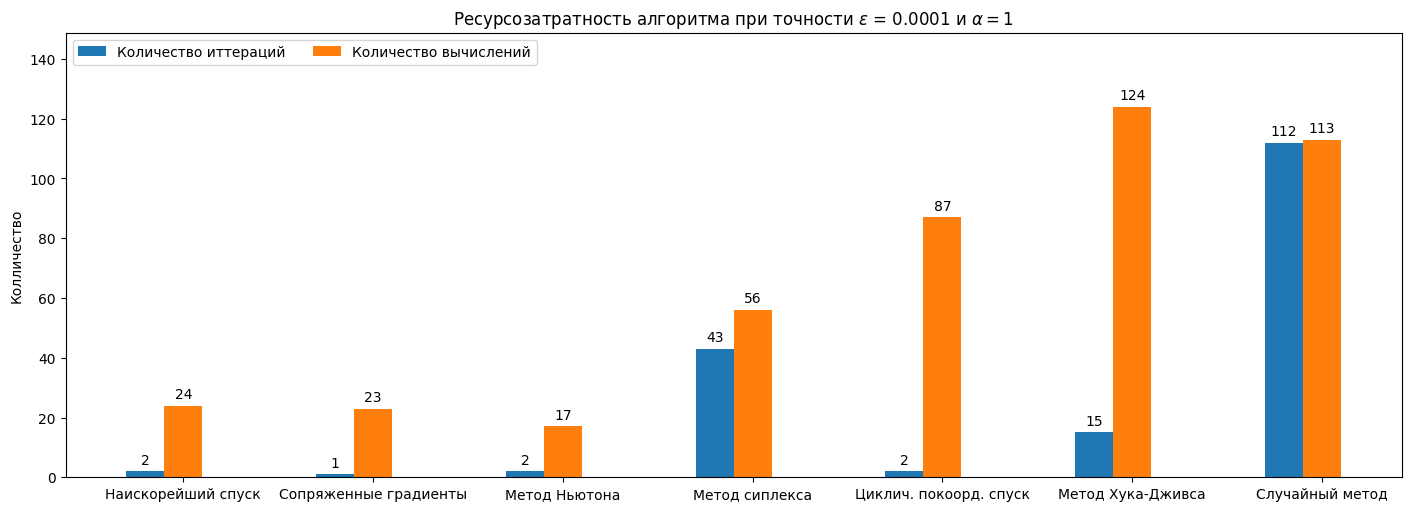

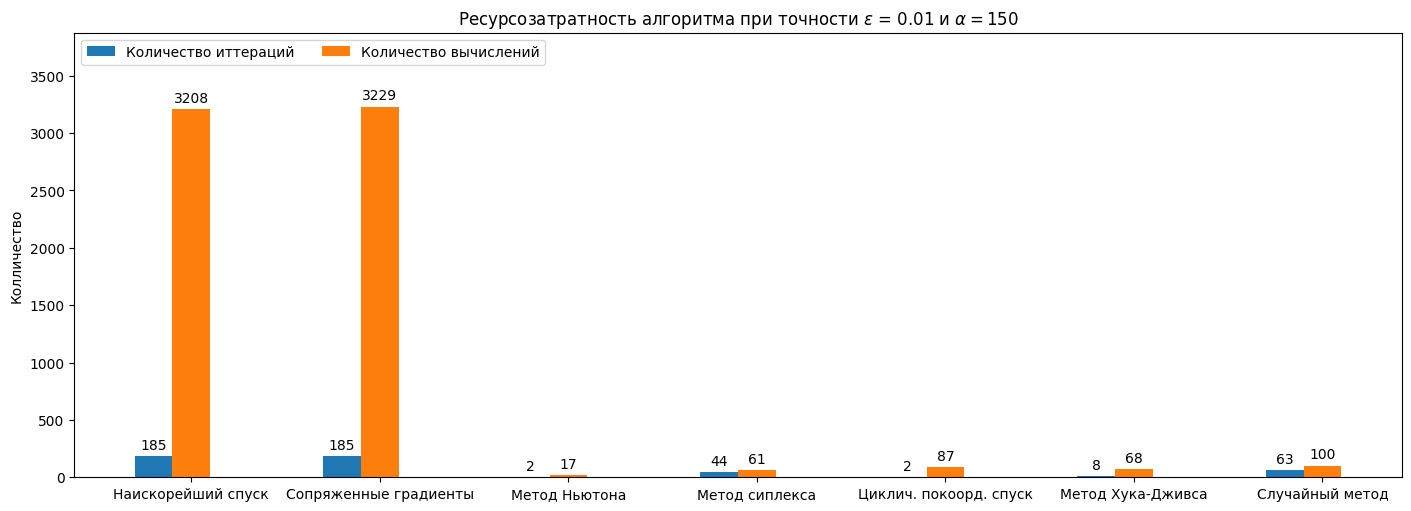

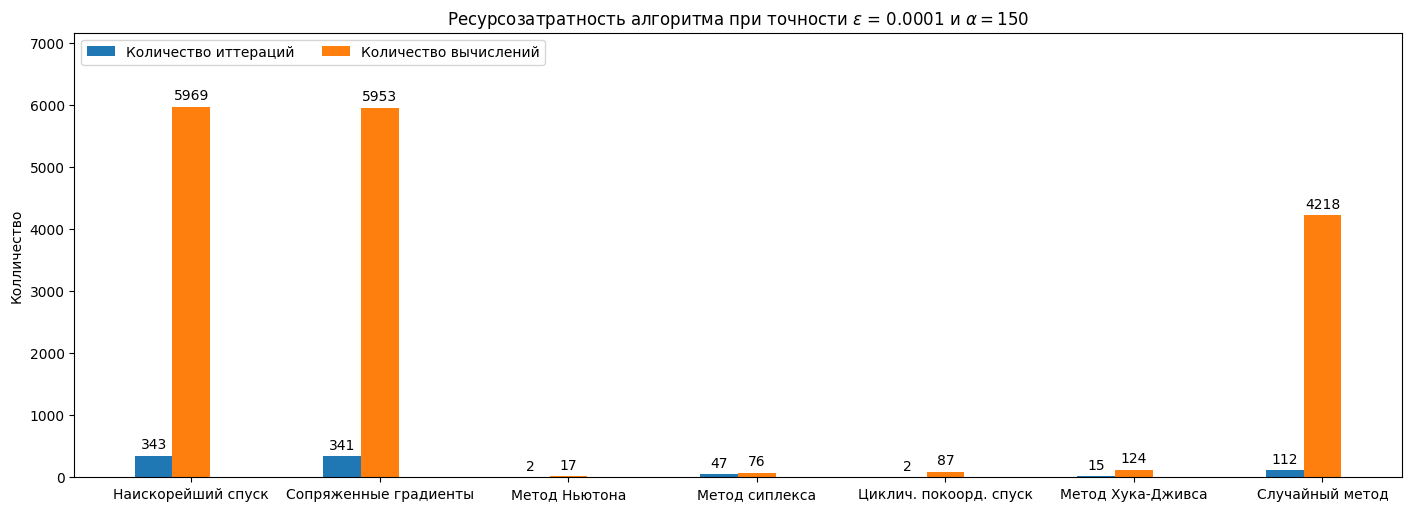

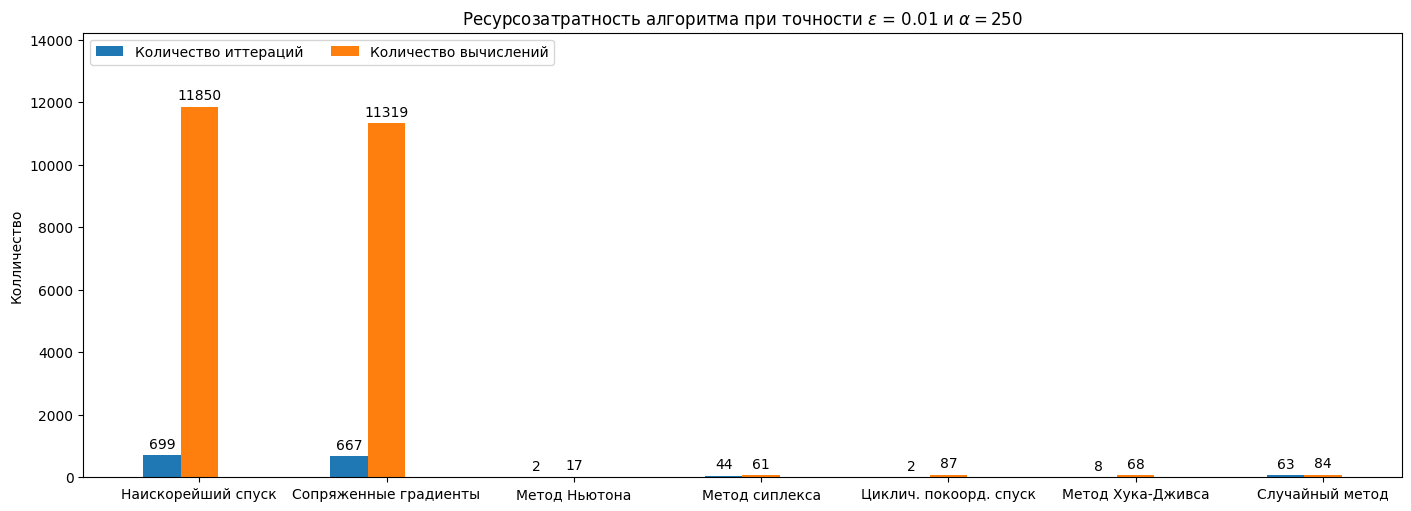

1000 --- 0.0010103972617520438


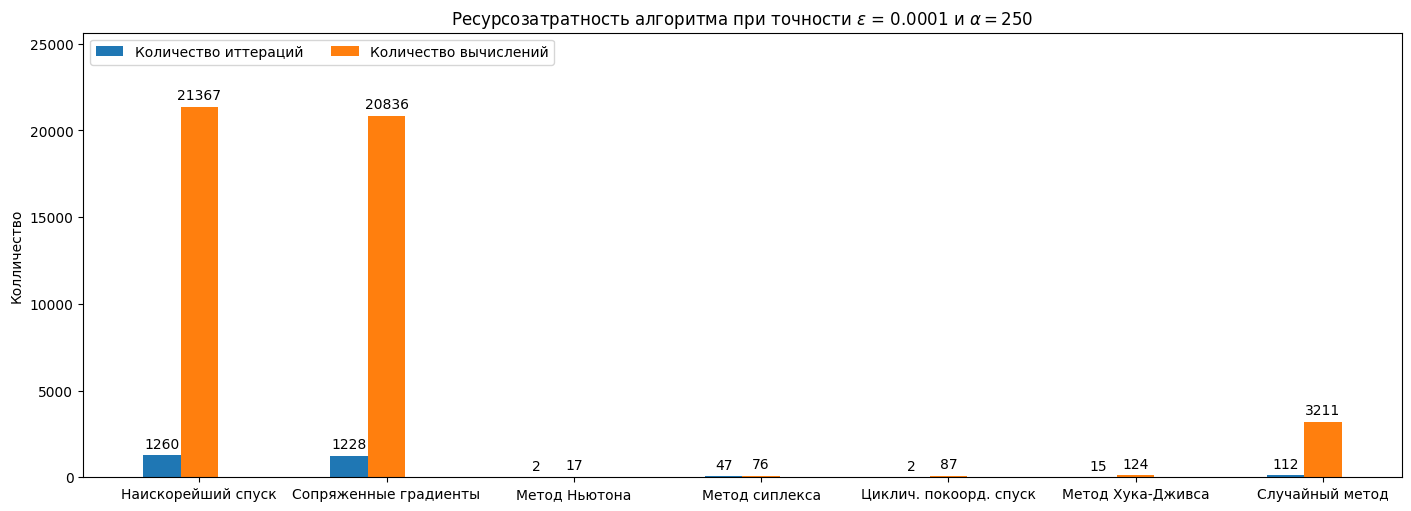

In [116]:
from sympy import Symbol
x, y = Symbol("x"), Symbol("y")

plt.rcParams['figure.figsize'] = [14, 5]

research_function = lambda alpha: x**2 + alpha * y**2
start_point = [1.0, -1.0]

for alpha in [1, 150, 250]:
    x, y = Symbol("x"), Symbol("y")
    research_function = lambda alpha: x**2 + alpha * y**2
    research_func_alpha = research_function(alpha)

    for research_eps in [10e-3, 10e-5]:
        x, y = Symbol("x"), Symbol("y")
        computes = {
            "Наискорейший спуск": fastest_downhill(research_func_alpha, start_point, research_eps),
            "Сопряженные градиенты": conjugate_gradients_method(research_func_alpha, start_point, research_eps),
            "Метод Ньютона": cool_newton_method(research_func_alpha, start_point, research_eps),
            "Метод сиплекса": simplex_method(research_func_alpha, start_point, research_eps),
            "Циклич. покоорд. спуск": cycle_coord_method(research_func_alpha, start_point, research_eps),
            "Метод Хука-Дживса": hooke_jeeves(research_func_alpha, start_point, research_eps),
            "Случайный метод": random_search_method(research_func_alpha, start_point, research_eps),
        }

        methods_name = computes.keys()
        compute_difficulty = {
            "Количество иттераций": [],
            "Количество вычислений": [],
        }
        for method_name in methods_name:
            compute_difficulty["Количество иттераций"].append(
                computes[method_name][2]
            )
            compute_difficulty["Количество вычислений"].append(
                computes[method_name][3]
            )
        
        x = np.arange(len(methods_name))  # the label locations
        width = 0.2  # the width of the bars
        multiplier = 0

        fig, ax = plt.subplots(layout='constrained')

        for attribute, measurement in compute_difficulty.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            ax.bar_label(rects, padding=3)
            multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Колличество')
        ax.set_title(f'Ресурсозатратность алгоритма при точности ' + r'$\epsilon$ = ' + str(research_eps) + " и " + r"$\alpha = $" + str(alpha))
        ax.set_xticks(x + width, methods_name)
        ax.legend(loc='upper left', ncols=3)
        ax.set_ylim(0, max(computes.values(), key=lambda x: x[3])[3] * 1.2)

        plt.show()

### Вывод
Градиентные методы примерно одинаково показали себя при минимизации функции данного вида, но при сильно овражной функции (коэффициент а=1000) метод сопряженных градиентов показал себя более эффективным, так как он избегает зигзагообразного характера приближения к точке минимума (выбор направления шага учитывает не только антиградиент, но и направление на предыдущем шаге). Метод Ньютона показал себя наиболее эффективным и сходился к точке минимума за одну итерацию, но это лишь из-за того, что это семейство функций является квадратичным (при минимизации функции от большего количества переменных вся вычислительная мощность лежала бы на вычислении обратного Гессиана). Метод регулярного симплекса очень неэффективен для минимизации сильно овражных функций, так как быстро опускается на «дно», а затем начинает медленно сходиться к минимуму. Остальные прямые методы минимизации показали себя стабильными для данного семейства функций.

---

## Задание 3
Выбрать для выполнения работы тестовую функцию, номер которой соответствует номеру Вашего компьютера.

Выбранная функция:
$$
f(x)=194x_{1}^{2}+376x_{1}x_{2}+194x_{2}^{2}+31x_{1}-229x_{2}+4
$$

---

## Задание 4

Сравнить эффективность методов для задачи п.2 при а=250 и тестовой функции п.3. Объяснить полученные результаты. 

In [117]:
from sympy import Symbol
x, y = Symbol("x"), Symbol("y")

plt.rcParams['figure.figsize'] = [14, 5]

start_point = [1.0, -1.0]

x, y = Symbol("x"), Symbol("y")
research_function = 194*x**2 + 376*x*y + 194*y**2 + 31*x - 229*y + 4

for research_eps in [10e-3, 10e-5]:
    x, y = Symbol("x"), Symbol("y")
    computes = {
        "Наискорейший спуск": fastest_downhill(research_function, start_point, research_eps),
        "Сопряженные градиенты": conjugate_gradients_method(research_function, start_point, research_eps),
        "Метод Ньютона": cool_newton_method(research_function, start_point, research_eps),
        "Метод сиплекса": simplex_method(research_function, start_point, research_eps),
        "Циклич. покоорд. спуск": cycle_coord_method(research_function, start_point, research_eps),
        "Метод Хука-Дживса": hooke_jeeves(research_function, start_point, research_eps),
        "Случайный метод": random_search_method(research_function, start_point, research_eps),
    }

    methods_name = computes.keys()
    compute_difficulty = {
        "Количество иттераций": [],
        "Количество вычислений": [],
    }
    for method_name in methods_name:
        compute_difficulty["Количество иттераций"].append(
            computes[method_name][2]
        )
        compute_difficulty["Количество вычислений"].append(
            computes[method_name][3]
        )
    
    x = np.arange(len(methods_name))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in compute_difficulty.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Колличество')
    ax.set_title(f'Ресурсозатратность алгоритма при точности ' + r'$\epsilon$ = ' + str(research_eps) + " и " + r"$\alpha = $" + str(alpha))
    ax.set_xticks(x + width, methods_name)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, max(computes.values(), key=lambda x: x[3])[3] * 1.2)

    plt.show()

1000 --- 337.3774176981267


KeyboardInterrupt: 